# Top End Assembly Vibration Study-- MTCamHexapod Telemetries

##### As described in OBS-467, we have been noticing strong vibrations on the Top End Assembly (TEA) of the Simonyi Survey Telescope (SST). The first time we saw these vibrations was on March 9th (Saturday) and on March 10th (Sunday).

##### Accordingly to SITCOM-1285, on March 15th (Friday), we ran soak tests using the Rotator at different configurations. We want to investigate any possible vibrations during that period to confirm the hypothesis that the Rotator could be causing this vibration.

#### Analysis details 

##### The idea is to explore possible sources and /or components affected by the vibrations. This analysis focusses on MTCam hexapods and vibrations it may/may not have experienced during the above event. 

##### Note: The natural frequency of both Camera and M2 hexapods is around 12 Hz. 
##### Douglas R Neill 2024 04 18
##### Regarding Bruno SITCOM-1285.
##### It is unlikely that the large accelerations of 1.2 m/s2 could be produced by anything other than the TMA drives. This contradicts the statements that the TMA was locked out at this time. The TEA has very low damping and a vibration amplification of 20 would not be unexpected. If the excitation is near a natural frequency, this could be produced by an excitation of only .06 m/s2 somewhere else. The natural frequencies of the camera and M2 on their hexapods are both around 12 Hz. This large acceleration is reported to be on the M2 surrogate, but I was later informed in a meeting that it is unclear where these accelerometers actually are.
##### The rotator is shown to have oscillation of order +/- .2 e-3 deg. The CG of ComCam is supposed to be off from the rotational axis of order 10mm. This rotation is consistent with the effects of transverse vibration being applied to the camera thru the TEA.  A transverse vibration would result in a small rotation. This effect can also be produced by a torque in the system produced by a wire, interference etc. I will just call it an out of balance.
##### Page 12. Both the SST M2 surrogate and the top end ring accelerometers show large accelerations. Knowing the frequency of these vibrations would be useful. The natural frequency of the hexapods are both around 12 Hz. This amplifies vibrations near this frequency, and attenuate them for frequencies greater than ~18 hz. If the excitation came from the camera or rotator and is around 12 Hz, it would excite the M2. If it is greater than 18 Hz it would be almost impossible for the camera or rotator to be producing this vibration. The strange rotations of the rotor are difficult to unexplained unless they are the result of a transverse impulse as described above.
##### If the excitation is from an external source, we would still expect to see some variations if the rotation is on or off. The rotator control system would attempt to counteract the vibration. The figures on Pages 18 and 19 show negligible change in the spider, M2 and top end vibrations with the rotator on or off.
##### Page 19 show M2 accelerations at frequencies of ~50 Hz. A frequency this high cannot come from the camera or rotator. It would be attenuated by their natural frequencies. The small vibration at ~12 hz is consistent with the M2 natural frequency. The ~50Hz may just be an error produced by 50 Hz power. Later it is theorized this is a data sampling error.
##### Bruno message at 3:50. Important clarification.  The maximum TMA acceleration is ~0.06G or 0.6 m/s2. The message says 0.6G. Easy to get this confused.
##### Bruno message 4:01 The figure shows spikes in the M2 IMS in the y direction corresponding with rotation in the rotator. This is consistent with an excitation of the top end in the y direction (rotation in the elevation axis) and a camera CG off set in the X direction. This would be true if the excitation was from an internal source, TMA drives or an internal source to the top end. However, there is nothing in the top end that can make this order of vibrations and the TMA drive system was off.
##### Bruno message 4:49. The motions of the M2 IMS are consistent with rotations in elevation. As the gravity vector changes the displacement changes between Y and Z. the X displacement is almost zero. The rotator angle is consistent with the elevation torque if there is an out of balance in the X. If we rotated the camera 90 degrees, we would expect this behavior to change substantially.
##### Bruno message 4:49 second plot. I am suspecting that we are seeing two manifestations of the same issue. Perhaps there is a larger out of balance in ComCam than is expected. This would produce rotations from Y vibration accelerations. The rotator might also have trouble holding its position.
##### After reviewing this message stream, I find it unlikely that the vibrations are produced by either the rotator or ComCam. They appear to be the recipients of the vibration and not the cause. I cannot see anything that could cause these levels of accelerations other than the TMA drives which are reported to be off.
##### It appears that all the tests were with the rotator at zero. I suspect that there is a large out of balance in ComCam which is causing a correlation between y displacement and rotation. This can be demonstrated by rotating near +/-90 degrees. The behavior should change significantly. If the out of balance is initially along the X direction it will now be along the Y direction. We would then see a correlation between X motion and rotation. The X motion is not produced by the elevation motion. It is only produced by Azimuth rotations away from zenith pointing.


### Import modules

In [15]:
%matplotlib inline
%matplotlib widget
from datetime import datetime
import time
from astropy.time import Time, TimeDelta
import os
from matplotlib.gridspec import GridSpec


import pandas as pd
from pandas.core.frame import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import detrend
from scipy.signal import get_window, welch

from lsst_efd_client import EfdClient


In [16]:
# Create a folder for plots
os.makedirs("./plots", exist_ok=True)

### Declaration of User-defined Functions

##### each of the demand and actual positions consist of 6 axes of motion (x,y,z,u,v,w). I will try with pulling out data for each of the axis to ensure the analysis works 
##### Note also that "salIndex"==1 ---> Camera Hexapod 
##### "salIndex"==2 ---> M2 Hexapod 
##### Hint: 

In [17]:
async def get_efd_data(
    efd_client: EfdClient,
    time_start: Time,
    time_end: Time,
) -> DataFrame:
    """Get the EFD data.

    Parameters
    ----------
    efd_client : `lsst_efd_client.EfdClient`
        EFD client.
    time_start : `astropy.time.Time`
        Start time.
    time_end : `astropy.time.Time`
        End time.

    Returns
    -------
    `pandas.core.frame.DataFrame`
        Queried data.
    """
    demand_topics = [f"demand{i}" for i in range(6)]
    pos_topics = [f"position{i}" for i in range(6)]
   
    data = await efd_client.select_time_series(
    "lsst.sal.MTHexapod.application", 
    fields=demand_topics + pos_topics+["timestamp","salIndex"], 
    start=time_start, 
    end=time_end)
    
    
    data_camhex = data[data["salIndex"] == 1]
    #data_m2hex = data[data["salIndex"] == 2]
    return data_camhex

In [34]:
def calculate_fft(data1: DataFrame,
                 n: int | None) -> None:
    """Plot the position and frequency data.

    Parameters
    ----------
    data : `pandas.core.frame.DataFrame`
        EFD data.
    


    """
    df = pd.DataFrame({'datetime': pd.to_datetime(data1.index)})
    #data["times"] = data.index
    #data["relative_time"] = data["times"] - data["times"].min()
    #data["relative_time"] = data["relative_time"].dt.total_seconds()
    timestamps =  df['datetime'].apply(lambda x: x.timestamp())
    timestamps = timestamps - timestamps.min()


    ##### FFT #######
    detrended_acc = detrend(data1[f"position{n}"])
    window = get_window("hamming", len(detrended_acc))
    windowed_acc = detrended_acc * window

    fft_acc = fft(windowed_acc)
    fft_freqs = fftfreq(
    len(windowed_acc),
    (timestamps[1] - timestamps[0]))

    positive_freqs = fft_freqs[: len(fft_freqs) // 2]
    positive_fft = np.abs(fft_acc[: len(fft_acc) // 2])

    max_freq = positive_freqs[positive_fft.argmax()]

    return(max_freq, positive_freqs, positive_fft)    
    
   


### Vibration time windows 

In [90]:
# Whole weekend
#start = Time("2024-03-09T10:00:00Z", scale="utc", format="isot")
#end = Time("2024-03-11T06:00:00Z", scale="utc", format="isot")

 # Zoom on weaker vibrations
#start = Time("2024-03-10T18:00:00Z", scale="utc", format="isot")
#end = Time("2024-03-11T03:00:00Z", scale="utc", format="isot")

# Zoom on strong vibrations
#name="strong"
#event="10 March 2024"
#start = Time("2024-03-10T03:00:00Z", scale="utc", format="isot")
#end = Time("2024-03-10T03:02:00Z", scale="utc", format="isot")

# non-vibration time - 2 min of data to be consistent
name="none"
event="09 March 2024"
start = Time("2024-03-09T10:00:00Z", scale="utc", format="isot")
end = Time("2024-03-09T10:02:00Z", scale="utc", format="isot")


### Initaite the EFD

In [91]:
efd_client = EfdClient("usdf_efd")

In [92]:
data = await get_efd_data(efd_client, start, end)

### CamHexapod-position

#### application n=0,1,2,3,4,5 correspond to x,y,z,u,v,w respectively. 

#### Figure 1 plot shows the actual positions (left) of first axes with positions um and the corresponding FFT frequency analysis (right)

In [93]:
pos=['X','Y','Z','U','V','W'] ## Hexapod application axes 

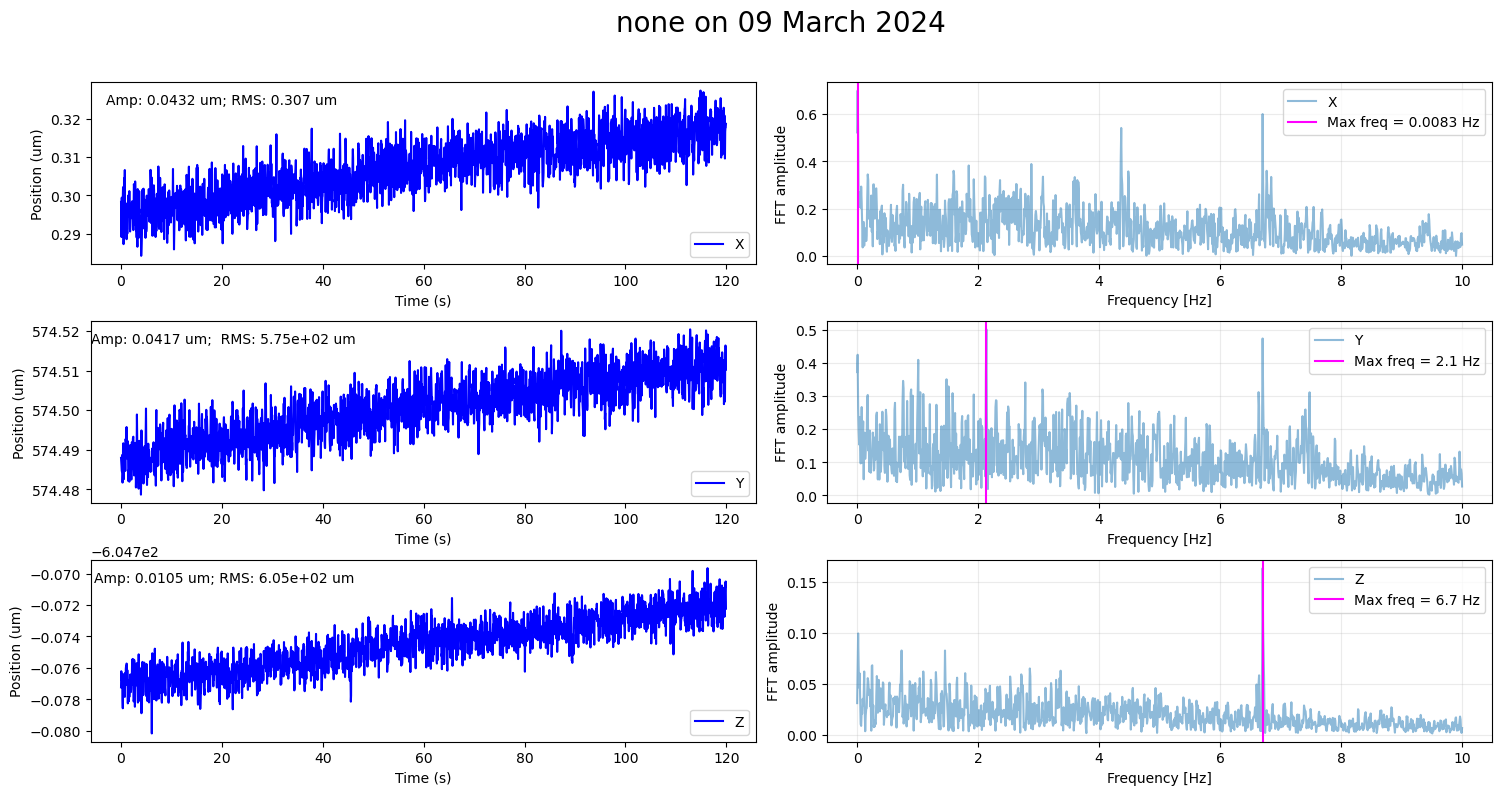

In [94]:
fig1 = plt.figure(figsize=(15,8))

gs = GridSpec(3, 2, figure=fig1)
ax00 = fig1.add_subplot(gs[0, 0])
ax01 = fig1.add_subplot(gs[0, 1])
ax10 = fig1.add_subplot(gs[1, 0])
ax11 = fig1.add_subplot(gs[1, 1])
ax20 = fig1.add_subplot(gs[2, 0])
ax21 = fig1.add_subplot(gs[2, 1])
fig1.suptitle(f"{name} on {event}", fontsize=20)
fig1.tight_layout(pad=2) 
#plt.title(f"{name} on {event}")

## Defining relative time in seconds -- Common to all the subplots
df = pd.DataFrame({'datetime': pd.to_datetime(data.index)})
    #data["times"] = data.index
    #data["relative_time"] = data["times"] - data["times"].min()
    #data["relative_time"] = data["relative_time"].dt.total_seconds()
timestamps =  df['datetime'].apply(lambda x: x.timestamp())
timestamps = timestamps - timestamps.min()

######## X #################

#------------- Position Plot --------------
actual_position0 = np.array(data[f"position0"])

amp0=np.ptp(actual_position0) # Amplitude
rms0=np.sqrt(np.mean(actual_position0**2)) # RMS 

ax00.plot(timestamps, actual_position0, "b")
ax00.set_xlabel("Time (s)")
ax00.set_ylabel("Position (um)")
ax00.legend([str(pos[0])])
ax00.text(0.2, 0.9, f"Amp: {amp0:.3} um; RMS: {rms0:.3} um ", horizontalalignment='center',
     verticalalignment='center', transform=ax00.transAxes)
#------- Position FFT -------------------
max_freq0, positive_freqs0, positive_fft0= calculate_fft(data, 0)

ax01.plot(positive_freqs0, positive_fft0, label=str(pos[0]), alpha=0.5)
ax01.axvline(max_freq0,
                color='magenta',
                label=f"Max freq = {max_freq0:.2} Hz")
ax01.grid(":", alpha=0.25)
    #print(f"Max freq: {max_freq}")
ax01.set_ylabel("FFT amplitude")
ax01.set_xlabel("Frequency [Hz]")
ax01.legend()

######## Y #################

#------------- Position Plot --------------
actual_position1 = np.array(data[f"position1"])

amp1=np.ptp(actual_position1) # Amplitude
rms1=np.sqrt(np.mean(actual_position1**2)) # RMS 

ax10.plot(timestamps, actual_position1, "b")
ax10.set_xlabel("Time (s)")
ax10.set_ylabel("Position (um)")
ax10.legend([str(pos[1])])
ax10.text(0.2, 0.9, f"Amp: {amp1:.3} um;  RMS: {rms1:.3} um", horizontalalignment='center',
     verticalalignment='center', transform=ax10.transAxes)
#--- Position FFT -------------------
max_freq1, positive_freqs1, positive_fft1= calculate_fft(data, 1)

ax11.plot(positive_freqs1, positive_fft1, label=str(pos[1]), alpha=0.5)
ax11.axvline(max_freq1,
                color='magenta',
                label=f"Max freq = {max_freq1:.2} Hz")
ax11.grid(":", alpha=0.25)
    #print(f"Max freq: {max_freq}")
ax11.set_ylabel("FFT amplitude")
ax11.set_xlabel("Frequency [Hz]")
ax11.legend()

######## Z #################

#------------- Position Plot --------------
actual_position2 = np.array(data[f"position2"])

amp2=np.ptp(actual_position2) # Amplitude
rms2=np.sqrt(np.mean(actual_position2**2)) # RMS 

ax20.plot(timestamps, actual_position2, "b")
ax20.set_xlabel("Time (s)")
ax20.set_ylabel("Position (um)")
ax20.legend([str(pos[2])])
ax20.text(0.2, 0.9, f"Amp: {amp2:.3} um; RMS: {rms2:.3} um", horizontalalignment='center',
     verticalalignment='center', transform=ax20.transAxes)

#------- Position FFT -------------------
max_freq2, positive_freqs2, positive_fft2= calculate_fft(data, 2)

ax21.plot(positive_freqs2, positive_fft2, label=str(pos[2]), alpha=0.5)
ax21.axvline(max_freq2,
                color='magenta',
                label=f"Max freq = {max_freq2:.2} Hz")
ax21.grid(":", alpha=0.25)
    #print(f"Max freq: {max_freq}")
ax21.set_ylabel("FFT amplitude")
ax21.set_xlabel("Frequency [Hz]")
ax21.legend()
    
plt.savefig(f"plots/camhex-position-xyz-{name}.png")
#plt.show()

#### Figure 2 plot shows the actual positions (left) of first axes with positions um and the corresponding FFT frequency analysis (right)

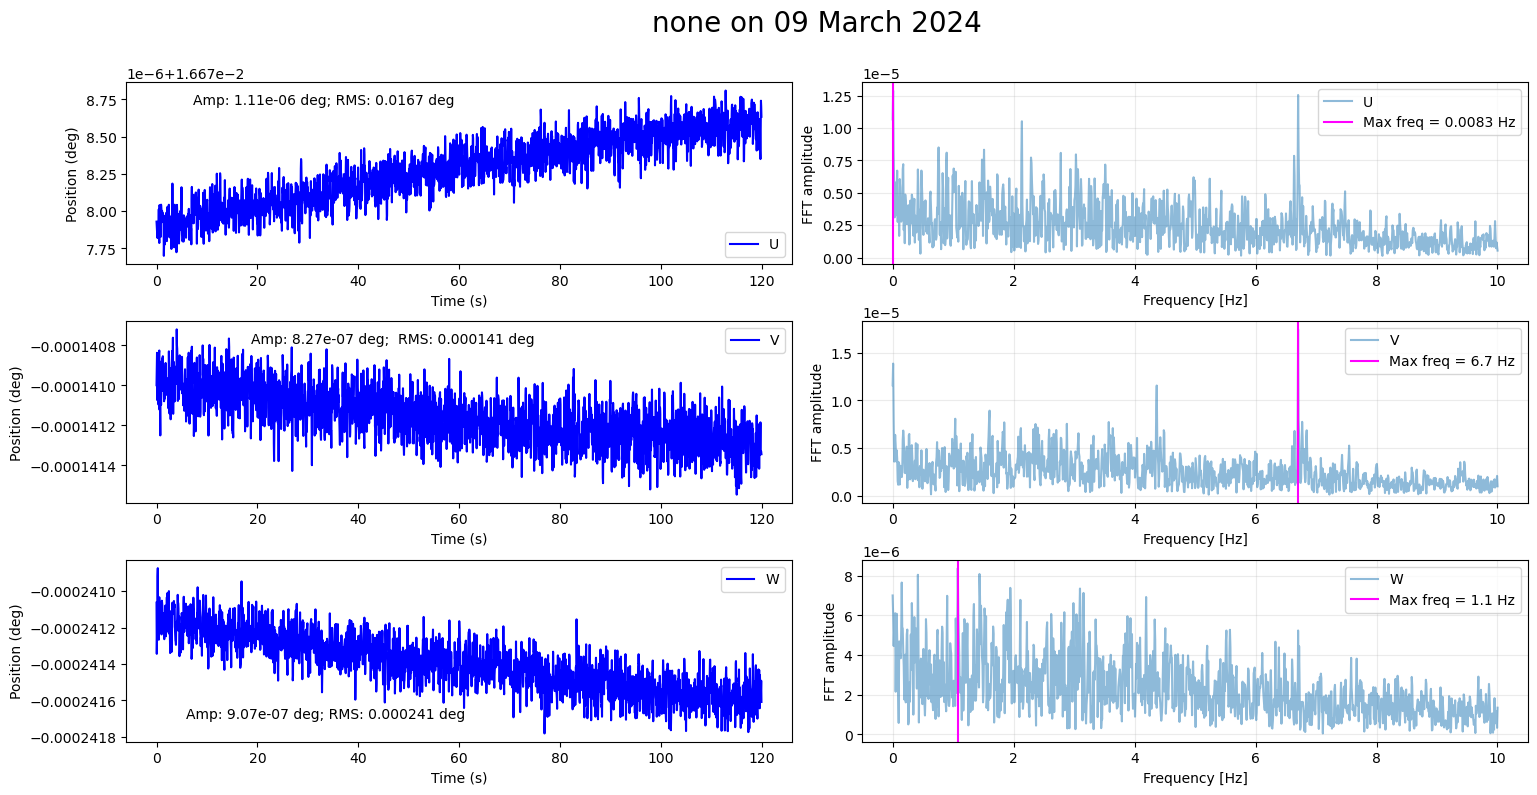

In [95]:
fig2 = plt.figure(figsize=(15,8))

gs2 = GridSpec(3, 2, figure=fig2)
ax00 = fig2.add_subplot(gs2[0, 0])
ax01 = fig2.add_subplot(gs2[0, 1])
ax10 = fig2.add_subplot(gs2[1, 0])
ax11 = fig2.add_subplot(gs2[1, 1])
ax20 = fig2.add_subplot(gs2[2, 0])
ax21 = fig2.add_subplot(gs2[2, 1])
fig2.suptitle(f"{name} on {event}", fontsize=20)
fig2.tight_layout(pad=2) 
#plt.title("Position")

## Defining relative time in seconds -- Common to all the subplots
df = pd.DataFrame({'datetime': pd.to_datetime(data.index)})
    #data["times"] = data.index
    #data["relative_time"] = data["times"] - data["times"].min()
    #data["relative_time"] = data["relative_time"].dt.total_seconds()
timestamps =  df['datetime'].apply(lambda x: x.timestamp())
timestamps = timestamps - timestamps.min()

######## U #################

#------------- Position Plot --------------
actual_position3 = np.array(data[f"position3"])

amp3=np.ptp(actual_position3) # Amplitude
rms3=np.sqrt(np.mean(actual_position3**2)) # RMS 

ax00.plot(timestamps, actual_position3, "b")
ax00.set_xlabel("Time (s)")
ax00.set_ylabel("Position (deg)")
ax00.legend([str(pos[3])])
ax00.text(0.3, 0.9, f"Amp: {amp3:.3} deg; RMS: {rms3:.3} deg ", horizontalalignment='center',
     verticalalignment='center', transform=ax00.transAxes)
#------- Position FFT -------------------
max_freq3, positive_freqs3, positive_fft3= calculate_fft(data, 3)

ax01.plot(positive_freqs3, positive_fft3, label=str(pos[3]), alpha=0.5)
ax01.axvline(max_freq3,
                color='magenta',
                label=f"Max freq = {max_freq3:.2} Hz")
ax01.grid(":", alpha=0.25)
    #print(f"Max freq: {max_freq}")
ax01.set_ylabel("FFT amplitude")
ax01.set_xlabel("Frequency [Hz]")
ax01.legend()

######## V #################

#------------- Position Plot --------------
actual_position4 = np.array(data[f"position4"])

amp4=np.ptp(actual_position4) # Amplitude
rms4=np.sqrt(np.mean(actual_position4**2)) # RMS 

ax10.plot(timestamps, actual_position4, "b")
ax10.set_xlabel("Time (s)")
ax10.set_ylabel("Position (deg)")
ax10.legend([str(pos[4])])
ax10.text(0.4, 0.9, f"Amp: {amp4:.3} deg;  RMS: {rms4:.3} deg", horizontalalignment='center',
     verticalalignment='center', transform=ax10.transAxes)
#--- Position FFT -------------------
max_freq4, positive_freqs4, positive_fft4= calculate_fft(data, 4)

ax11.plot(positive_freqs4, positive_fft4, label=str(pos[4]), alpha=0.5)
ax11.axvline(max_freq4,
                color='magenta',
                label=f"Max freq = {max_freq4:.2} Hz")
ax11.grid(":", alpha=0.25)
    #print(f"Max freq: {max_freq}")
ax11.set_ylabel("FFT amplitude")
ax11.set_xlabel("Frequency [Hz]")
ax11.legend()

######## W #################

#------------- Position Plot --------------
actual_position5 = np.array(data[f"position5"])

amp5=np.ptp(actual_position5) # Amplitude
rms5=np.sqrt(np.mean(actual_position5**2)) # RMS 

ax20.plot(timestamps, actual_position5, "b")
ax20.set_xlabel("Time (s)")
ax20.set_ylabel("Position (deg)")
ax20.legend([str(pos[5])])
ax20.text(0.3, 0.15, f"Amp: {amp5:.3} deg; RMS: {rms5:.3} deg", horizontalalignment='center',
     verticalalignment='center', transform=ax20.transAxes)

#------- Position FFT -------------------
max_freq5, positive_freqs5, positive_fft5= calculate_fft(data, 5)

ax21.plot(positive_freqs5, positive_fft5, label=str(pos[5]), alpha=0.5)
ax21.axvline(max_freq5,
                color='magenta',
                label=f"Max freq = {max_freq5:.2} Hz")
ax21.grid(":", alpha=0.25)
    #print(f"Max freq: {max_freq}")
ax21.set_ylabel("FFT amplitude")
ax21.set_xlabel("Frequency [Hz]")
ax21.legend()
    
plt.savefig(f"plots/camhex-position-uvw-{name}.png")
#plt.show()

## EFD Data extraction checks

In [30]:
data.index

DatetimeIndex(['2024-03-10 18:00:00.017448+00:00',
               '2024-03-10 18:00:00.067498+00:00',
               '2024-03-10 18:00:00.117483+00:00',
               '2024-03-10 18:00:00.167528+00:00',
               '2024-03-10 18:00:00.217561+00:00',
               '2024-03-10 18:00:00.267564+00:00',
               '2024-03-10 18:00:00.317555+00:00',
               '2024-03-10 18:00:00.367590+00:00',
               '2024-03-10 18:00:00.417626+00:00',
               '2024-03-10 18:00:00.467679+00:00',
               ...
               '2024-03-11 02:59:59.507932+00:00',
               '2024-03-11 02:59:59.557952+00:00',
               '2024-03-11 02:59:59.608036+00:00',
               '2024-03-11 02:59:59.657981+00:00',
               '2024-03-11 02:59:59.707967+00:00',
               '2024-03-11 02:59:59.757972+00:00',
               '2024-03-11 02:59:59.807718+00:00',
               '2024-03-11 02:59:59.858010+00:00',
               '2024-03-11 02:59:59.908038+00:00',
            

In [31]:
df = pd.DataFrame({
    'datetime': pd.to_datetime(data.index)
})

In [32]:
df['seconds'] = df['datetime'].apply(lambda x: x.timestamp())
print(df)

                               datetime       seconds
0      2024-03-10 18:00:00.017448+00:00  1.710094e+09
1      2024-03-10 18:00:00.067498+00:00  1.710094e+09
2      2024-03-10 18:00:00.117483+00:00  1.710094e+09
3      2024-03-10 18:00:00.167528+00:00  1.710094e+09
4      2024-03-10 18:00:00.217561+00:00  1.710094e+09
...                                 ...           ...
647787 2024-03-11 02:59:59.757972+00:00  1.710126e+09
647788 2024-03-11 02:59:59.807718+00:00  1.710126e+09
647789 2024-03-11 02:59:59.858010+00:00  1.710126e+09
647790 2024-03-11 02:59:59.908038+00:00  1.710126e+09
647791 2024-03-11 02:59:59.958035+00:00  1.710126e+09

[647792 rows x 2 columns]
